In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [12]:
# import sys
# sys.path.insert(0, '../')

import numpy as np
import tensorflow as tf
import data
import utils
import plot as plots
import evaluation
from model import WGanModel
from gan import CosmoGAN

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"


# Parameters

In [73]:
ns = 32
k = 20
try_resume = False
Mpch=350

# Data handling

Load the data

In [74]:
dataset = data.load.load_2d_dataset(resolution=256,Mpch=Mpch, k=k,spix=ns)

min: -0.9900000095367432
max: 0.9897927641868591


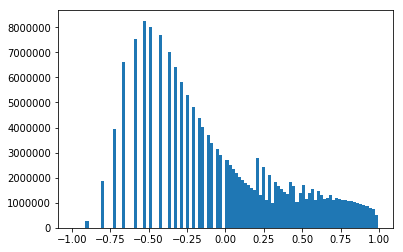

In [76]:
X = dataset.get_all_data()
nel = np.prod(X.shape)
Xvec = np.reshape(X,[nel])
hist(Xvec, 100)
print('min: {}'.format(min(Xvec)))
print('max: {}'.format(max(Xvec)))

Let us plot 16 images

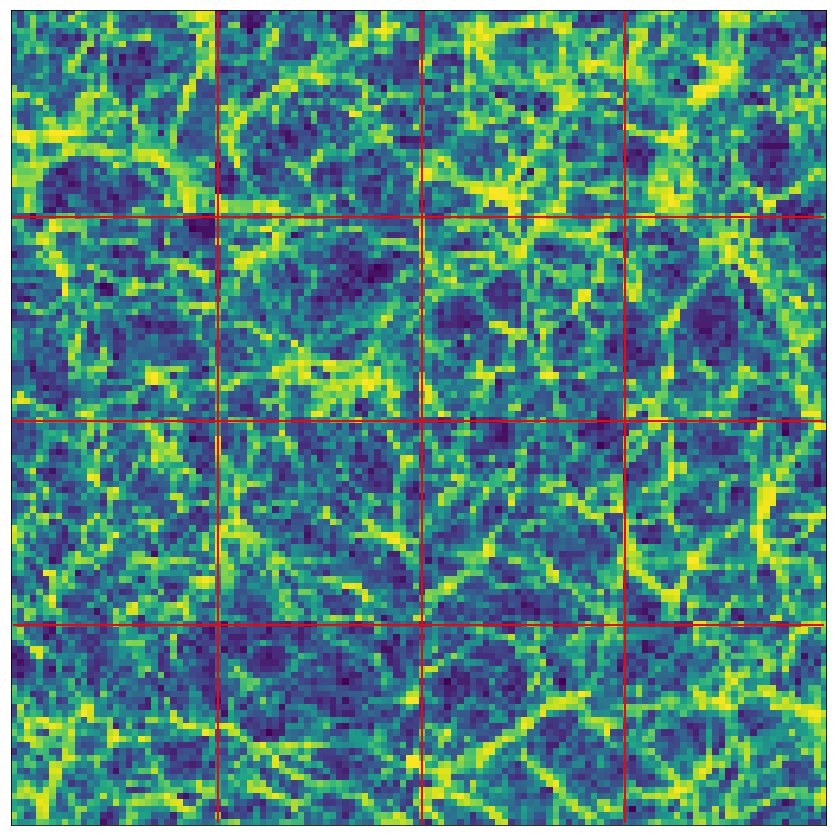

In [75]:
plt.figure(figsize=(15,15))
plots.draw_images(dataset.get_samples(N=16),nx=4,ny=4)

# A) The WGAN

In [77]:
time_str = 'test_{}'.format(Mpch)
global_path = '../../saved_result/'

name = 'WGAN{}'.format(ns)

## Parameters

In [78]:
bn = False

params_discriminator = dict()
params_discriminator['stride'] = [2, 2, 2]
params_discriminator['nfilter'] = [16, 32, 32]
params_discriminator['shape'] = [[5, 5],[5, 5], [5, 5]]
params_discriminator['batch_norm'] = [bn, bn, bn]
params_discriminator['full'] = [32]
params_discriminator['minibatch_reg'] = True
params_discriminator['summary'] = True

params_generator = dict()
params_generator['stride'] = [2, 1, 1]
params_generator['latent_dim'] = 100
params_generator['nfilter'] = [32, 64, 1]
params_generator['shape'] = [[5, 5], [5, 5], [5, 5]]
params_generator['batch_norm'] = [bn, bn]
params_generator['full'] = [16*16*32]
params_generator['summary'] = True
params_generator['non_lin'] = 'tanh'

params_optimization = dict()
params_optimization['gamma_gp'] = 10
params_optimization['batch_size'] = 16
params_optimization['gen_optimizer'] = 'rmsprop' # rmsprop / adam / sgd
params_optimization['disc_optimizer'] = 'rmsprop' # rmsprop / adam /sgd
params_optimization['disc_learning_rate'] = 3e-5
params_optimization['gen_learning_rate'] = 3e-5
params_optimization['beta1'] = 0.9
params_optimization['beta2'] = 0.999
params_optimization['epsilon'] = 1e-8
params_optimization['epoch'] = 100


params_cosmology = dict()
params_cosmology['clip_max_real'] = True
params_cosmology['log_clip'] = 0.1
params_cosmology['sigma_smooth'] = 1
params_cosmology['k'] = k
params_cosmology['Npsd'] = 500


params = dict()
params['generator'] = params_generator
params['discriminator'] = params_discriminator
params['optimization'] = params_optimization
params['cosmology'] = params_cosmology

params['normalize'] = False
params['image_size'] = [ns, ns]
params['prior_distribution'] = 'gaussian'
params['sum_every'] = 500
params['viz_every'] = 500
params['print_every'] = 100
params['save_every'] = 2000
params['name'] = name
params['summary_dir'] = global_path + params['name'] + '_' + time_str +'_summary/'
params['save_dir'] = global_path + params['name'] + '_' + time_str + '_checkpoints/'

In [79]:
resume, params = utils.test_resume(try_resume, params)

## Build the model

In [80]:
wgan = CosmoGAN(params, WGanModel)

Generator 
------------------------------------------------------------
     The input is of size (?, 100)
     0 Full layer with 8192 outputs
         Size of the variables: (?, 8192)
     Reshape to (?, 16, 16, 32)
     1 Deconv layer with 32 channels
         Size of the variables: (?, 32, 32, 32)
     2 Deconv layer with 64 channels
         Size of the variables: (?, 32, 32, 64)
     3 Deconv layer with 1 channels
         Size of the variables: (?, 32, 32, 1)
    Non lienarity: tanh
     The output is of size (?, 32, 32, 1)
------------------------------------------------------------

Discriminator 
------------------------------------------------------------
     The input is of size (?, 32, 32, 1)
     0 Conv layer with 16 channels
         Size of the variables: (?, 16, 16, 16)
     1 Conv layer with 32 channels
         Size of the variables: (?, 8, 8, 32)
     2 Conv layer with 32 channels
         Size of the variables: (?, 4, 4, 32)
     Reshape to (?, 512)
     3 Full lay

## Train the model
Note that the input is the processed data... Maybe, we should change that

In [81]:
wgan.train(dataset, resume=resume)

Erase recursively directory: ../../saved_result/WGAN32_test_350_summary/
Erase recursively directory: ../../saved_result/WGAN32_test_350_checkpoints/
Epoch: [ 0] [  99/ 160] Counter:100	( 0.1 min	231.940 examples/sec	0.07 sec/batch)	L_Disc:-0.19345951	L_Gen:-2.62873697
Epoch: [ 1] [  39/ 160] Counter:200	( 0.2 min	243.796 examples/sec	0.07 sec/batch)	L_Disc:-1.58778310	L_Gen:-2.07146215
Epoch: [ 1] [ 139/ 160] Counter:300	( 0.3 min	245.153 examples/sec	0.07 sec/batch)	L_Disc:-2.29508519	L_Gen:-1.02795911
Epoch: [ 2] [  79/ 160] Counter:400	( 0.4 min	251.430 examples/sec	0.06 sec/batch)	L_Disc:-2.86250281	L_Gen:-0.33674172
Epoch: [ 3] [  19/ 160] Counter:500	( 0.6 min	220.744 examples/sec	0.07 sec/batch)	L_Disc:-3.72650886	L_Gen:-0.58930874
 [*] [Fake, Real] Min [6.265, 1.238],	Median [11.614,16.478],	Mean [1.188E+01,6.485E+01],	Max [1.936E+01,7.262E+03],	Var [6.566E+00,1.967E+05]
 [*] [Comp, Fake, Real] PeakDistance:[1.298, 0.116, 1.558]	CrossPS:[1.381, 2.816, -1.242]
 [*] New PSD Low 

Epoch: [26] [ 139/ 160] Counter:4300	( 5.9 min	247.001 examples/sec	0.06 sec/batch)	L_Disc:-0.16783065	L_Gen:1.94519520
Epoch: [27] [  79/ 160] Counter:4400	( 6.0 min	249.404 examples/sec	0.06 sec/batch)	L_Disc:-0.16870561	L_Gen:2.20535612
Epoch: [28] [  19/ 160] Counter:4500	( 6.1 min	203.318 examples/sec	0.08 sec/batch)	L_Disc:-0.24140295	L_Gen:2.23078299
 [*] [Fake, Real] Min [0.819, 1.192],	Median [17.238,15.857],	Mean [5.835E+01,5.828E+01],	Max [1.278E+04,5.946E+03],	Var [2.001E+06,1.570E+05]
 [*] [Comp, Fake, Real] PeakDistance:[1.194, 0.683, 1.449]	CrossPS:[-1.189, -2.611, 0.003]
 4500 current PSD L2 112942.37639709185, logL2 8.056708665944987
Epoch: [28] [ 119/ 160] Counter:4600	( 6.4 min	105.279 examples/sec	0.15 sec/batch)	L_Disc:-0.20237975	L_Gen:2.01974106
Epoch: [29] [  59/ 160] Counter:4700	( 6.5 min	251.340 examples/sec	0.06 sec/batch)	L_Disc:-0.18733822	L_Gen:2.29365301
Epoch: [29] [ 159/ 160] Counter:4800	( 6.6 min	245.156 examples/sec	0.07 sec/batch)	L_Disc:-0.2034497

Epoch: [55] [  99/ 160] Counter:8900	(12.4 min	203.557 examples/sec	0.08 sec/batch)	L_Disc:-0.18229012	L_Gen:2.23780441
Epoch: [56] [  39/ 160] Counter:9000	(12.5 min	249.927 examples/sec	0.06 sec/batch)	L_Disc:-0.27616516	L_Gen:2.81796074
 [*] [Fake, Real] Min [1.203, 1.216],	Median [17.153,16.942],	Mean [1.482E+02,6.545E+01],	Max [4.735E+04,6.995E+03],	Var [1.354E+07,1.850E+05]
 [*] [Comp, Fake, Real] PeakDistance:[1.959, 1.754, 1.529]	CrossPS:[1.506, 1.348, -0.653]
 9000 current PSD L2 5056123.174453694, logL2 54.194472679167916
Epoch: [56] [ 139/ 160] Counter:9100	(12.7 min	104.129 examples/sec	0.15 sec/batch)	L_Disc:-0.17486775	L_Gen:2.72587729
Epoch: [57] [  79/ 160] Counter:9200	(12.9 min	202.711 examples/sec	0.08 sec/batch)	L_Disc:-0.35391361	L_Gen:2.94468188
Epoch: [58] [  19/ 160] Counter:9300	(13.0 min	272.684 examples/sec	0.06 sec/batch)	L_Disc:-0.26212808	L_Gen:2.94427729
Epoch: [58] [ 119/ 160] Counter:9400	(13.0 min	283.278 examples/sec	0.06 sec/batch)	L_Disc:-0.33492672

Epoch: [84] [  59/ 160] Counter:13500	(18.7 min	245.615 examples/sec	0.07 sec/batch)	L_Disc:-0.17217827	L_Gen:2.91728973
 [*] [Fake, Real] Min [0.867, 1.200],	Median [15.974,16.682],	Mean [7.825E+01,6.352E+01],	Max [2.473E+04,6.681E+03],	Var [4.826E+06,1.947E+05]
 [*] [Comp, Fake, Real] PeakDistance:[1.414, 0.883, 1.381]	CrossPS:[0.886, -3.328, -1.910]
 13500 current PSD L2 1334706.4401768064, logL2 30.604864779505995
Epoch: [84] [ 159/ 160] Counter:13600	(19.0 min	97.697 examples/sec	0.16 sec/batch)	L_Disc:-0.06817509	L_Gen:2.91685534
Epoch: [85] [  99/ 160] Counter:13700	(19.1 min	285.080 examples/sec	0.06 sec/batch)	L_Disc:-0.08590429	L_Gen:3.35890317
Epoch: [86] [  39/ 160] Counter:13800	(19.2 min	267.393 examples/sec	0.06 sec/batch)	L_Disc:-0.15391052	L_Gen:3.15438128
Epoch: [86] [ 139/ 160] Counter:13900	(19.3 min	246.406 examples/sec	0.06 sec/batch)	L_Disc:-0.20410480	L_Gen:2.41641760
Epoch: [87] [  79/ 160] Counter:14000	(19.4 min	245.530 examples/sec	0.07 sec/batch)	L_Disc:-0.

In [82]:
gen_sample, gen_sample_raw = wgan.generate(N=500)
gen_sample = np.squeeze(gen_sample)
gen_sample_raw = np.squeeze(gen_sample_raw)

 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../saved_result/WGAN32_test_350_checkpoints/WGAN32-16001


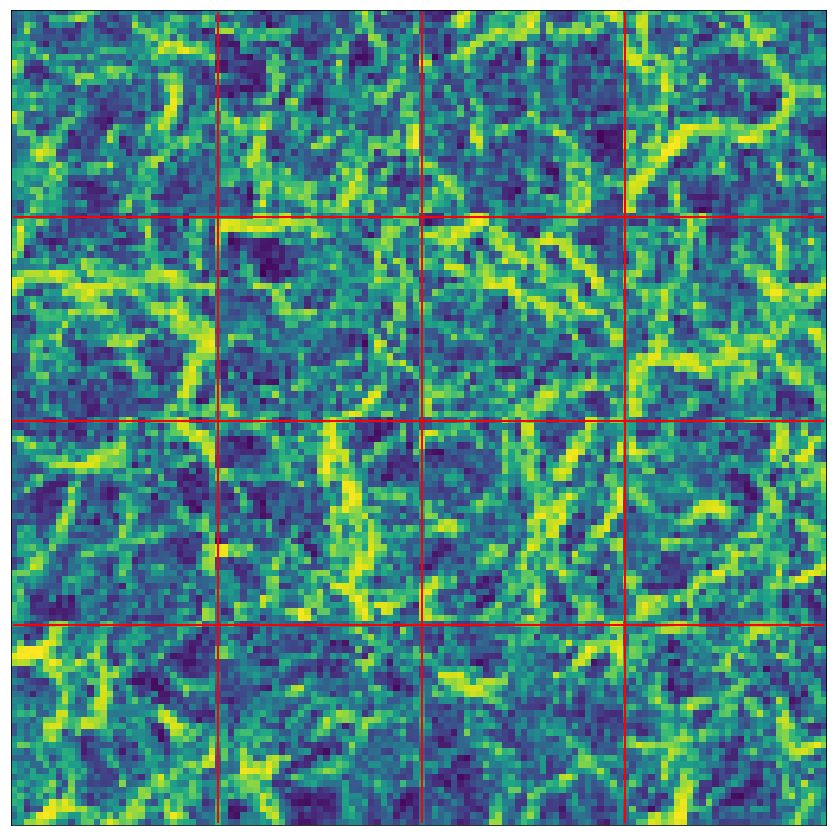

In [83]:
plt.figure(figsize=(15,15))
plots.draw_images(gen_sample,nx=4,ny=4)

In [84]:
raw_images = utils.backward_map(dataset.get_samples(dataset.N), k=k)

Log l2 PSD loss: 39.450614728693644
L2 PSD loss: 1930953.0042743904
Log l1 PSD loss: 5.853977825795478
L1 PSD loss: 1384.9661126858764


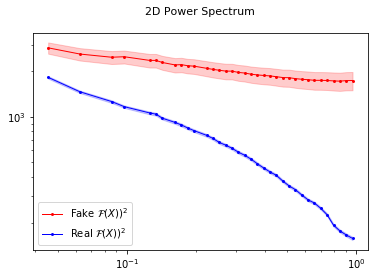

In [85]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_psd(raw_images, gen_sample_raw)

Log l2 Peak Count loss: 6.466193989759435
L2 Peak Count loss: 0.23151451781005855
Log l1 Peak Count loss: 1.8562760665347153
L1 Peak Count loss: 0.34593046875000005


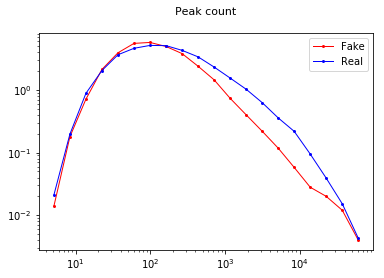

In [86]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_peak_cout(raw_images, gen_sample_raw)

Log l2 Mass histogram loss: 10.665474441849584
L2 Peak Mass histogram: 35.6492353379883
Log l1 Mass histogram loss: 2.1204346150523166
L1 Mass histogram loss: 3.386021875


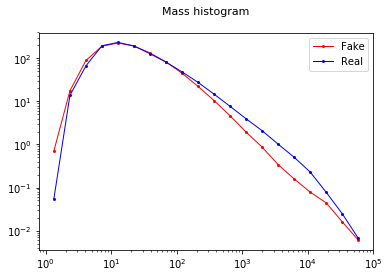

In [87]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_mass_hist(raw_images, gen_sample_raw)